# New approach to evaluating models  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to establish a new approach to evaluating models for this contest.  I propose a method which borrows from the **K-Folds** and **Leave-one-out** methods, wherein we build the model several times; each model is built by leaving out one well as the test set.  This method is designed to circumvent the circumstances of the contest wherein the prediction capability for the predefined blind well (**Newby**) is a loss function - leading to overfitting.  

Time to load supporting libraries and the data!

In [64]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# machine learning packages
library(e1071)
library(caret)

In [7]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# convert NM_M channel into a binary channel "isMarine"
data$NM_M <- data$NM_M == "2"
names(data)[10] <- "isMarine"

# make the Facies channel more descriptive
levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")

# remove any incomplete records (we know from jpoirier001.ipynb PE channel is missing some values)
data <- data[complete.cases(data),]

# display first five rows of data set
head(data)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


## 2 Tuning SVM parameters

Noww let's apply our well-folds methodology wherein we loop through the wells and the current well iteration functions as the cross-validation data set while the remaining wells function as the training data.  Our tuning in *jpoirier001.ipynb* found that (using the randomly split data) the optimal SVM parameters were 10 for **Cost** and 1 for **Gamma**.  The tuning function tried **Cost** values of 0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, and 10000 and **Gamma** values of 0.0001, 0.001, 0.01, 1, and 10.  Since we're going to apply this computationally intensive procedure multiple times, let's trim off a few of the end values.  

Also note that we will not isolate the **Recruit F9** "well" because it is not a true well but a manually selected set of observations of the Bafflestone facies.

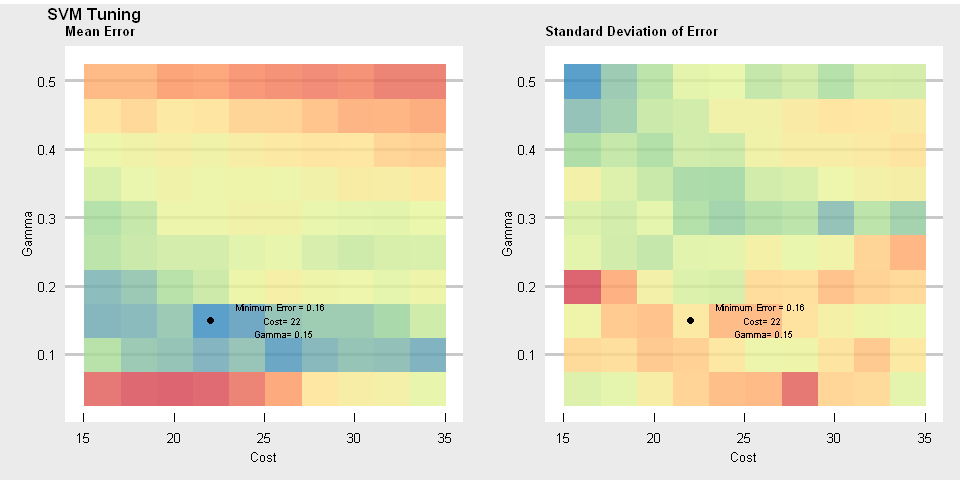

In [112]:
tune_svm <- function(data, well) {
    # isolate the well data
    cvIndex <- data$Well.Name == well
    cv <- data[cvIndex,]
    
    # apply tuning and return performances
    tune.out <- tune(svm, Facies ~ ., data=cv, 
                 kernel="radial",
                 ranges=list(cost=c(16,18,20,22,24,26,28,30,32,34),
                            gamma=c(.05,.1,.15,.2,.25,.3,.35,.4,.45,.5)))
    
    tune.out$performances
}

well_folds <- function(data, fxn) {
    # list of wells
    wells <- unique(data$Well.Name)
    wells <- wells[-(which(wells == "Recruit F9"))]
    
    # initialize performances data frame
    performances <- data.frame(cost=numeric(), gamma=numeric(), error=numeric(), dispersion=numeric(), well=factor())
    
    # tune algorithm for each well, record and return performance
    for (well in wells) {
        temp <- fxn(data, well)
        temp$well <- well
        performances <- rbind(performances, temp)
    }
    performances
}

# tune the svm parameters
tuning <- well_folds(data, tune_svm)

# extract the unique cost and gamma values used
costs <- unique(tuning$cost)
gammas <- unique(tuning$gamma)

# initialize dataframe for statistics
df <- data.frame(cost=numeric(), 
                 gamma=numeric(), 
                 mean_error=numeric(), 
                 sd_error=numeric(), 
                 mean_dispersion=numeric(),
                 sd_dispersion=numeric())

# loop through costs and gammas vectors, calc stats for each pair
for (cost in costs) {
    for (gamma in gammas) {
        temp <- tuning[tuning$cost == cost & tuning$gamma == gamma,]
        
        mean_error <- mean(temp$error)
        sd_error <- sd(temp$error)
        mean_dispersion <- mean(temp$dispersion)
        sd_dispersion <- sd(temp$dispersion)
        
        df <- rbind(df, data.frame(cost=cost, 
                                   gamma=gamma, 
                                   mean_error=mean_error, 
                                   sd_error=sd_error, 
                                   mean_dispersion=mean_dispersion, 
                                   sd_dispersion=sd_dispersion))
    }
}
dfmin <- df[which.min(df$mean_error),]

options(repr.plot.width=8, repr.plot.height=4)

# mean error across wells
g1 <- ggplot(df, aes(cost, gamma, fill=mean_error)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmin, aes(cost, gamma)) +
    geom_text(aes(x=dfmin$cost[1]+4, y=dfmin$gamma[1], 
                  label=paste("Minimum Error =", round(dfmin$mean_error,2), 
                              "\n Cost=", dfmin$cost[1], "\n Gamma=", dfmin$gamma[1])), 
              size=2) +
    labs(x="Cost", y="Gamma", title="Mean Error") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# standard deviation of errors across wells
g2 <- ggplot(df, aes(cost, gamma, fill=sd_error)) + theme_economist_white(gray_bg=T) +
    geom_raster(alpha=.8) +
    geom_point(data=dfmin, aes(cost, gamma)) +
    geom_text(aes(x=dfmin$cost[1]+4, y=dfmin$gamma[1], 
                  label=paste("Minimum Error =", round(dfmin$mean_error,2), 
                              "\n Cost=", dfmin$cost[1], "\n Gamma=", dfmin$gamma[1])), 
              size=2) +
    labs(x="Cost", y="Gamma", title="Standard Deviation of Error") +
    scale_fill_distiller(palette="Spectral", name="", direction=-1) +
    theme(legend.position='none', 
          plot.title=element_text(size=8), 
          axis.text=element_text(size=8),
          axis.title=element_text(size=8),
          legend.text=element_text(size=8))

# bring two plots together and display
g <- plot_grid(g1, g2, ncol=2)
ggdraw() + 
    draw_plot(g, width=1, height=1, y=-.01) + 
    draw_plot_label("SVM Tuning", size=10)